In [1]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [2]:
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

print("✅ Earth Engine initialized")


✅ Earth Engine initialized


In [3]:
krakow = ee.Geometry.Point([19.9449799, 50.0646501]).buffer(25_000)
print("✅ Kraków ROI ready")


✅ Kraków ROI ready


In [4]:
EMB = ee.ImageCollection("GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL")
CLC2018 = ee.Image("COPERNICUS/CORINE/V20/100m/2018").select("landcover")

print("✅ Datasets loaded")


✅ Datasets loaded


In [5]:
def corine_urban_mask(aoi):
    clc = CLC2018.clip(aoi)
    # Artificial surfaces = 1xx (100-199)
    urban = clc.gte(100).And(clc.lt(200)).rename("urban").toByte()
    return urban

urban2018 = corine_urban_mask(krakow)

# Quick sanity check
urban_sum = urban2018.reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=krakow,
    scale=100,
    maxPixels=1e13
).get("urban")

print("✅ CORINE urban pixels (sum):", ee.Number(urban_sum).getInfo())


✅ CORINE urban pixels (sum): 43081.45882352941


In [6]:
def emb_year(year, aoi):
    col = (EMB
           .filterDate(f"{year}-01-01", f"{year+1}-01-01")
           .filterBounds(aoi))
    
    # median reduces seams vs mosaic
    return col.mosaic().clip(aoi)


In [7]:
K = 30  # improvement: more clusters = better separation (try 12, 20, 30)

emb2018 = emb_year(2018, krakow)

# sampling at 100m matches CORINE resolution better
samples = emb2018.sample(
    region=krakow,
    scale=100,
    numPixels=12000,
    seed=42,
    geometries=False
)

clusterer = ee.Clusterer.wekaKMeans(K).train(samples)

print("✅ KMeans trained with K =", K)


✅ KMeans trained with K = 30


In [8]:
def cluster_map(year):
    emb = emb_year(year, krakow)
    return emb.cluster(clusterer).rename("cluster")


In [9]:
def cluster_urban_score(cluster_img, urban_mask, aoi):
    stacked = urban_mask.rename("urban").addBands(cluster_img.rename("cluster"))

    stats = stacked.reduceRegion(
        reducer=ee.Reducer.mean().group(groupField=1, groupName="cluster"),
        geometry=aoi,
        scale=100,
        maxPixels=1e13
    )

    groups = ee.List(stats.get("groups")).getInfo()

    out = {}
    for g in groups:
        out[int(g["cluster"])] = float(g["mean"])
    return out

cl2018 = cluster_map(2018)
urban_scores = cluster_urban_score(cl2018, urban2018, krakow)

urban_scores


{0: 0.7311451497029242,
 1: 0.31663756207994725,
 2: 0.07859762145434272,
 3: 0.004475557438827779,
 4: 0.0685148883061873,
 5: 0.025050548981389403,
 6: 0.023342609247864975,
 7: 0.05172036462338301,
 8: 0.0885327266020209,
 9: 0.012182578912155618,
 10: 0.74388765970893,
 11: 0.9586597289031289,
 12: 0.030398473429744537,
 13: 0.7256569109745251,
 14: 0.43916517480098743,
 15: 0.042933909086793114,
 16: 0.03398113108176446,
 17: 0.055350240086974895,
 18: 0.9773416211490459,
 19: 0.6754322865514395,
 20: 0.17296852626523762,
 21: 0.03543607811441679,
 22: 0.03698007833496791,
 23: 0.004294447531955743,
 24: 0.04012645526174757,
 25: 0.9894837616908462,
 26: 0.026362541983494327,
 27: 0.013172968350891809,
 28: 0.013736021554494502,
 29: 0.2869992572109124}

In [10]:
sorted_scores = sorted(urban_scores.items(), key=lambda x: x[1], reverse=True)
print("Top urban clusters:", sorted_scores[:5])
print("Top non-urban clusters:", sorted_scores[-5:])


Top urban clusters: [(25, 0.9894837616908462), (18, 0.9773416211490459), (11, 0.9586597289031289), (10, 0.74388765970893), (0, 0.7311451497029242)]
Top non-urban clusters: [(28, 0.013736021554494502), (27, 0.013172968350891809), (9, 0.012182578912155618), (3, 0.004475557438827779), (23, 0.004294447531955743)]


In [19]:
cl2018 = cluster_map(2018)

m = geemap.Map()
m.centerObject(krakow, 9)

# random-ish palette for clusters (K up to ~30 is fine)
palette = [
    "1f77b4","ff7f0e","2ca02c","d62728","9467bd",
    "8c564b","e377c2","7f7f7f","bcbd22","17becf",
    "aec7e8","ffbb78","98df8a","ff9896","c5b0d5",
    "c49c94","f7b6d2","c7c7c7","dbdb8d","9edae5",
    "393b79","637939","8c6d31","843c39","7b4173",
    "5254a3","6b6ecf","9c9ede","cedb9c","e7cb94"
]

m.addLayer(
    cl2018,
    {"min": 0, "max": K-1, "palette": palette[:K]},
    f"KMeans clusters (2018) K={K}"
)

m.addLayer(krakow, {}, "ROI")
m

Map(center=[50.06467574696253, 19.944981007960628], controls=(WidgetControl(options=['position', 'transparent_…

In [11]:
URBAN_T = 0.70
NONURBAN_T = 0.10

urban_clusters = [c for c, s in urban_scores.items() if s >= URBAN_T]
nonurban_clusters = [c for c, s in urban_scores.items() if s <= NONURBAN_T]

print("Urban clusters:", urban_clusters)
print("Non-urban clusters:", nonurban_clusters)


Urban clusters: [0, 10, 11, 13, 18, 25]
Non-urban clusters: [2, 3, 4, 5, 6, 7, 8, 9, 12, 15, 16, 17, 21, 22, 23, 24, 26, 27, 28]


In [12]:
def three_class_from_clusters(cluster_img):
    urban = cluster_img.remap(urban_clusters, [1]*len(urban_clusters), 0)
    nonurban = cluster_img.remap(nonurban_clusters, [1]*len(nonurban_clusters), 0)

    uncertain = urban.Not().And(nonurban.Not())
    cls = nonurban.multiply(0).add(uncertain.multiply(1)).add(urban.multiply(2)).rename("cls")
    return cls


In [13]:
def area_km2(mask, aoi, scale=100):
    pix_area_km2 = ee.Image.pixelArea().divide(1e6)
    area_img = pix_area_km2.updateMask(mask)
    s = area_img.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=aoi,
        scale=scale,
        maxPixels=1e13
    )
    return float(s.get("area").getInfo()) if s.get("area") else 0.0


years = list(range(2018, 2025))  # 2018..2024
rows = []

for y in years:
    cl = cluster_map(y)
    cls = three_class_from_clusters(cl)

    urban_mask = cls.eq(2).rename("area")
    urban_km2 = area_km2(urban_mask, krakow, scale=100)

    rows.append({"year": y, "urban_km2": urban_km2})

df = pd.DataFrame(rows)
df


,year,urban_km2
0,2018,309.182709
1,2019,310.968341
2,2020,378.203126
3,2021,341.274158
4,2022,368.190813
5,2023,406.593304
6,2024,349.774323


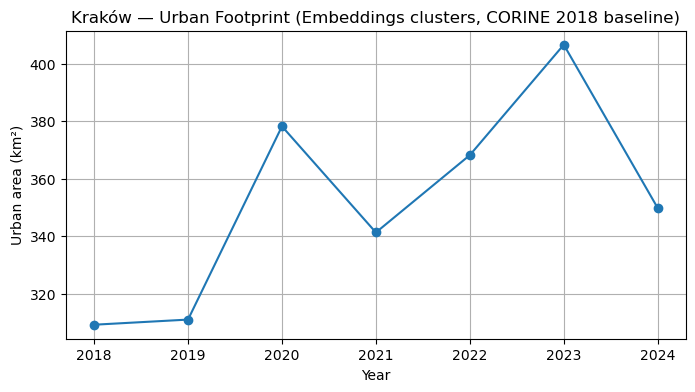

In [14]:
plt.figure(figsize=(8,4))
plt.plot(df["year"], df["urban_km2"], marker="o")
plt.xlabel("Year")
plt.ylabel("Urban area (km²)")
plt.title("Kraków — Urban Footprint (Embeddings clusters, CORINE 2018 baseline)")
plt.grid(True)
plt.show()


In [15]:
cls_2018 = three_class_from_clusters(cluster_map(2018))
cls_2024 = three_class_from_clusters(cluster_map(2024))

urban18 = cls_2018.eq(2)
urban24 = cls_2024.eq(2)

uncertain = cls_2018.eq(1).Or(cls_2024.eq(1))
gain = urban18.Not().And(urban24)
loss = urban18.And(urban24.Not())

# 0=no change, 1=gain, 2=loss, 3=uncertain
change = (gain.multiply(1)
          .add(loss.multiply(2))
          .add(uncertain.multiply(3))).rename("change")

print("✅ Change map ready")


✅ Change map ready


In [16]:
m = geemap.Map()
m.centerObject(krakow, 9)

change_vis = {"min": 0, "max": 3,
              "palette": ["000000", "00ff00", "ff0000", "ffff00"]}

palette_3class = ["0000ff", "aaaaaa", "ff0000"]  # nonurban / uncertain / urban

m.addLayer(cls_2018, {"min":0, "max":2, "palette":palette_3class}, "3-class 2018")
m.addLayer(cls_2024, {"min":0, "max":2, "palette":palette_3class}, "3-class 2024")
m.addLayer(change, change_vis, "Change 2018→2024 (gain/loss/uncertain)")
m


Map(center=[50.06467574696253, 19.944981007960628], controls=(WidgetControl(options=['position', 'transparent_…

In [17]:
pred2018 = three_class_from_clusters(cluster_map(2018)).eq(2).rename("pred")
gt2018 = urban2018.rename("gt")

val = pred2018.addBands(gt2018).sample(
    region=krakow, scale=100, numPixels=5000, seed=0, geometries=False
)

pred = np.array(val.aggregate_array("pred").getInfo())
gt   = np.array(val.aggregate_array("gt").getInfo())

TP = np.sum((pred==1) & (gt==1))
FP = np.sum((pred==1) & (gt==0))
FN = np.sum((pred==0) & (gt==1))

precision = TP / (TP + FP + 1e-9)
recall    = TP / (TP + FN + 1e-9)
f1        = 2*precision*recall/(precision+recall+1e-9)

print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)


Precision: 0.8517060367442891
Recall: 0.5976058931854534
F1: 0.7023809518955615
